In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from qRNN import *

In [35]:
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [36]:
def prepare_data(data, time_steps):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return torch.Tensor(x), torch.Tensor(y)

np.random.seed(42)

In [37]:
stock_symbol = "AAPL"
start_date = "2022-01-01"
end_date = "2024-01-01"
stock_data = download_stock_data(stock_symbol, start_date, end_date)

closing_prices = stock_data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

time_steps = 4

x, y = prepare_data(closing_prices_scaled, time_steps)

split_ratio = 0.8
train_size = int(len(x) * split_ratio)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(x_train.shape)

[*********************100%%**********************]  1 of 1 completed

torch.Size([397, 4, 1])


In [38]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return (labels - predictions) ** 2

def cost(weights, rotations, X):
    loss = 0
    for xs, label in X:
        hidden_state = torch.zeros((1,))
        for x in xs:
            out = circuit(weights, rotations, x, hidden_state)
            prediction = out[0]
            hidden_state = out[1:]
        loss += square_loss(label, prediction)
    
    return loss/batch_size

#train, test = dill.load(open('temperature_processed.pkl', 'rb'))

optimizer = Adam([weights, rotations], lr=0.001)

epoch = 200
batch_size = 397


loss_history = []

def accuracy(predicted_sequence, true_sequence):
    return 1-np.mean(np.abs( np.square((predicted_sequence - true_sequence)/true_sequence)) )

def closure():
    batch = list(zip(x_train, y_train))#random.choices(list(zip(x_train, y_train)), k=batch_size)
    optimizer.zero_grad()
    loss = cost(weights, rotations, batch)
    loss.backward()
    return loss

In [39]:
for i in tqdm(range(epoch)):
    loss = optimizer.step(closure)
    loss_history.append(loss.item())
    if i % 10 == 0 and i > 0:
        print(loss.item())

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 11/200 [01:50<31:10,  9.90s/it]

0.022812210023403168


 10%|█         | 21/200 [03:43<34:24, 11.53s/it]

0.018732372671365738


 16%|█▌        | 31/200 [05:42<33:39, 11.95s/it]

0.015328365378081799


 20%|██        | 41/200 [07:40<30:35, 11.55s/it]

0.01254130620509386


 26%|██▌       | 51/200 [09:19<22:08,  8.91s/it]

0.010270384140312672


 30%|███       | 61/200 [10:42<19:10,  8.28s/it]

0.008442015387117863


 36%|███▌      | 71/200 [12:51<28:53, 13.44s/it]

0.0069915251806378365


 40%|████      | 81/200 [15:16<32:47, 16.53s/it]

0.0058587598614394665


 46%|████▌     | 91/200 [17:53<24:20, 13.40s/it]

0.004987224005162716


 50%|█████     | 101/200 [19:19<14:21,  8.71s/it]

0.004325779154896736


 56%|█████▌    | 111/200 [20:44<12:37,  8.51s/it]

0.0038290913216769695


 60%|██████    | 121/200 [22:09<11:17,  8.57s/it]

0.0034587476402521133


 66%|██████▌   | 131/200 [23:34<09:50,  8.56s/it]

0.0031834542751312256


 70%|███████   | 141/200 [25:00<08:29,  8.63s/it]

0.002978425705805421


 76%|███████▌  | 151/200 [26:26<06:50,  8.38s/it]

0.0028245376888662577


 80%|████████  | 161/200 [27:50<05:24,  8.32s/it]

0.002707382896915078


 86%|████████▌ | 171/200 [29:53<07:26, 15.41s/it]

0.002616318641230464


 90%|█████████ | 181/200 [32:27<04:03, 12.80s/it]

0.002543657086789608


 96%|█████████▌| 191/200 [33:50<01:15,  8.39s/it]

0.002483953721821308


100%|██████████| 200/200 [35:04<00:00, 10.52s/it]


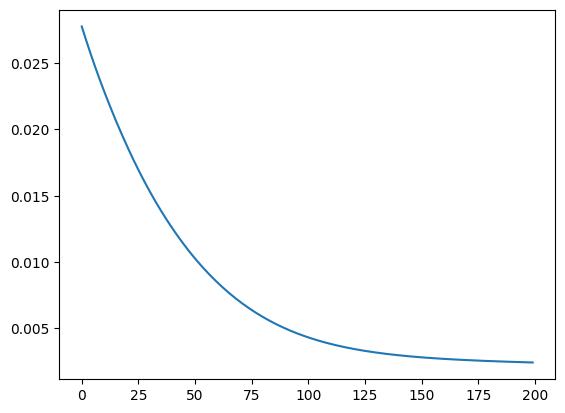

497


In [40]:
plt.plot(loss_history)
plt.show()

print(len(x))

In [41]:
with torch.no_grad():
    predictions = []  
    for stock in x_test:
        hidden_state = torch.zeros((1,))
        for x in stock:
            out = circuit(weights, rotations, x, hidden_state)
            prediction = out[0]
            hidden_state = out[1:]
        predictions.append(prediction)


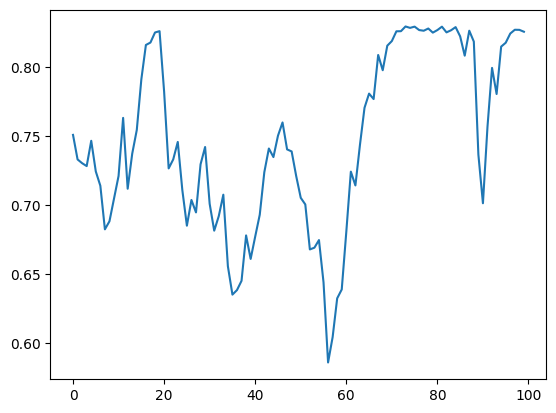

In [42]:
plt.plot(predictions)
predictions = torch.Tensor(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

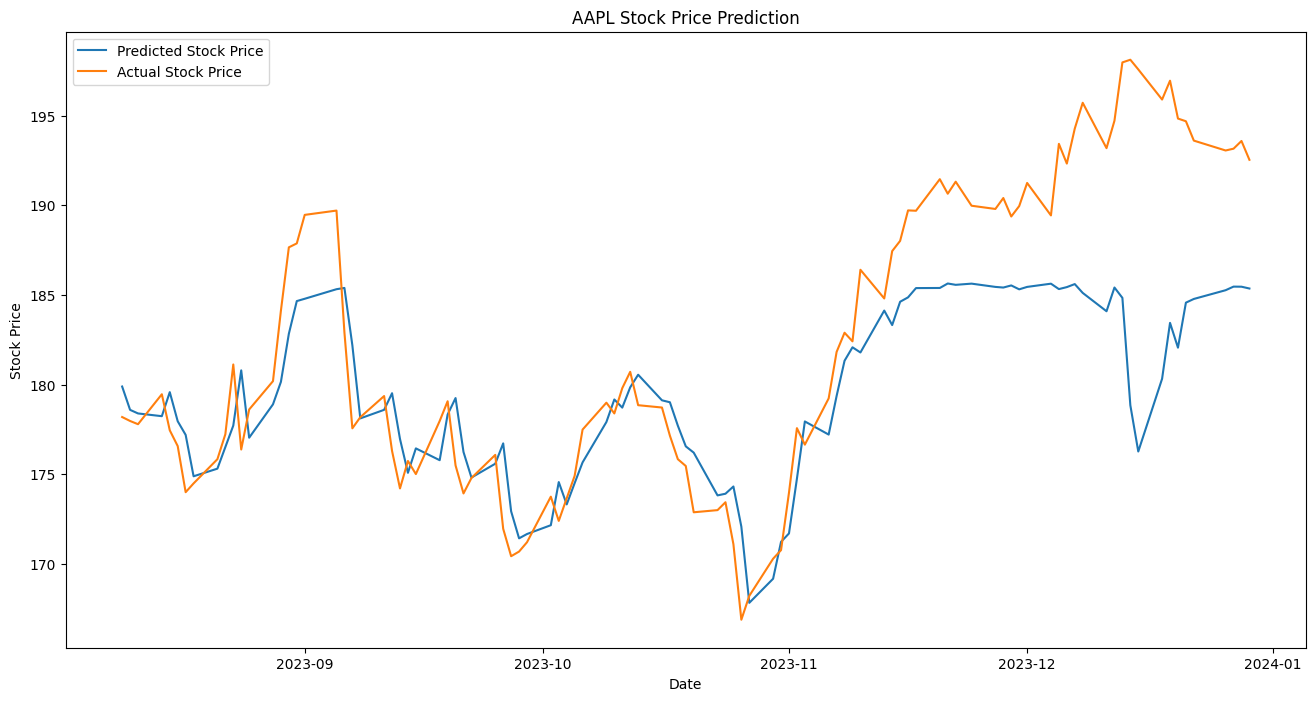

In [43]:
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted Stock Price')
plt.plot(stock_data.index[-len(predictions):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Stock Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [44]:
acc = accuracy(predictions, scaler.inverse_transform(y_test.reshape(-1, 1)))
acc

0.999151125205359

In [45]:
class StockRNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, layer_dim=10):
        super(StockRNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.layer_dim = layer_dim
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = None

    def forward(self, input_seq):
        self.hidden_cell = torch.zeros(self.layer_dim, input_seq.size(0), self.hidden_layer_size)
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), -1, 1), self.hidden_cell)
        predictions = self.linear(rnn_out.view(len(input_seq), -1))
        return predictions[-1]

In [46]:
model = StockRNN(layer_dim=time_steps).to('cpu')

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = 'cpu'

In [47]:
epochs = 200
for i in tqdm(range(epochs)):
    loss = 0
    for seq, labels in zip(x_train, y_train):
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        model.hidden_cell = torch.zeros(1, 1, model.hidden_layer_size).to(device)

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        loss += single_loss
    loss /= x_train.size(0)
    loss.backward()
    optimizer.step()
    
    if i % 2 == 0:
        model.eval()

        with torch.no_grad():
            loss = []
            for seq, labels in test:
                seq, labels = seq.to(device), labels.to(device)
                model.hidden_cell = torch.zeros(1, 1, model.hidden_layer_size).to(device)
                y_pred = model(seq)
                loss.append(loss_function(y_pred, labels))
            print(f"Loss: {np.mean(loss)}")   


        #print(f'Epoch {i+1} loss: {single_loss.item()}')

print(f'Epoch {epochs} loss: {loss.item()}')

  1%|          | 2/200 [00:00<00:51,  3.87it/s]

Loss: 0.07481405138969421


  2%|▏         | 4/200 [00:00<00:38,  5.07it/s]

Loss: 0.06089029088616371


  3%|▎         | 6/200 [00:01<00:35,  5.53it/s]

Loss: 0.069304458796978


  4%|▍         | 8/200 [00:01<00:33,  5.75it/s]

Loss: 0.10248174518346786


  5%|▌         | 10/200 [00:01<00:32,  5.86it/s]

Loss: 0.16399511694908142


  6%|▌         | 12/200 [00:02<00:31,  5.93it/s]

Loss: 0.2519996166229248


  7%|▋         | 14/200 [00:02<00:31,  5.93it/s]

Loss: 0.3448757827281952


  8%|▊         | 16/200 [00:02<00:30,  5.94it/s]

Loss: 0.39982473850250244


  9%|▉         | 18/200 [00:03<00:30,  5.93it/s]

Loss: 0.3976345360279083


 10%|█         | 20/200 [00:03<00:30,  5.91it/s]

Loss: 0.3558865785598755


 11%|█         | 22/200 [00:03<00:29,  5.94it/s]

Loss: 0.3004451394081116


 12%|█▏        | 24/200 [00:04<00:29,  5.99it/s]

Loss: 0.24918881058692932


 13%|█▎        | 26/200 [00:04<00:28,  6.00it/s]

Loss: 0.21002651751041412


 14%|█▍        | 28/200 [00:04<00:28,  6.00it/s]

Loss: 0.18424440920352936


 15%|█▌        | 30/200 [00:05<00:28,  5.99it/s]

Loss: 0.1702384203672409


 16%|█▌        | 32/200 [00:05<00:28,  5.98it/s]

Loss: 0.16581189632415771


 17%|█▋        | 34/200 [00:05<00:27,  5.96it/s]

Loss: 0.16902735829353333


 18%|█▊        | 36/200 [00:06<00:27,  5.94it/s]

Loss: 0.17815670371055603


 19%|█▉        | 38/200 [00:06<00:27,  5.95it/s]

Loss: 0.191233828663826


 20%|██        | 40/200 [00:07<00:27,  5.90it/s]

Loss: 0.2056097537279129


 21%|██        | 42/200 [00:07<00:26,  5.91it/s]

Loss: 0.21790103614330292


 22%|██▏       | 44/200 [00:07<00:27,  5.68it/s]

Loss: 0.22466249763965607


 23%|██▎       | 46/200 [00:08<00:26,  5.82it/s]

Loss: 0.22366665303707123


 24%|██▍       | 48/200 [00:08<00:26,  5.83it/s]

Loss: 0.21493156254291534


 25%|██▌       | 50/200 [00:08<00:25,  5.93it/s]

Loss: 0.20061446726322174


 26%|██▌       | 52/200 [00:09<00:24,  5.96it/s]

Loss: 0.18388870358467102


 27%|██▋       | 54/200 [00:09<00:24,  5.89it/s]

Loss: 0.1676878035068512


 28%|██▊       | 56/200 [00:09<00:24,  5.93it/s]

Loss: 0.15397745370864868


 29%|██▉       | 58/200 [00:10<00:23,  5.92it/s]

Loss: 0.143601655960083


 30%|███       | 60/200 [00:10<00:23,  5.94it/s]

Loss: 0.13641411066055298


 31%|███       | 62/200 [00:10<00:23,  5.98it/s]

Loss: 0.13143354654312134


 32%|███▏      | 64/200 [00:11<00:22,  5.96it/s]

Loss: 0.12696100771427155


 33%|███▎      | 66/200 [00:11<00:22,  5.99it/s]

Loss: 0.12084362655878067


 34%|███▍      | 68/200 [00:11<00:22,  5.95it/s]

Loss: 0.11118356138467789


 35%|███▌      | 70/200 [00:12<00:21,  5.97it/s]

Loss: 0.09736982733011246


 36%|███▌      | 72/200 [00:12<00:21,  5.95it/s]

Loss: 0.08060262352228165


 37%|███▋      | 74/200 [00:12<00:21,  5.99it/s]

Loss: 0.06331878900527954


 38%|███▊      | 76/200 [00:13<00:20,  5.97it/s]

Loss: 0.047903284430503845


 39%|███▉      | 78/200 [00:13<00:20,  5.97it/s]

Loss: 0.03552044555544853


 40%|████      | 80/200 [00:13<00:20,  5.92it/s]

Loss: 0.02576746605336666


 41%|████      | 82/200 [00:14<00:19,  5.92it/s]

Loss: 0.01738184317946434


 42%|████▏     | 84/200 [00:14<00:19,  5.97it/s]

Loss: 0.009753778576850891


 43%|████▎     | 86/200 [00:14<00:19,  5.98it/s]

Loss: 0.004109982866793871


 44%|████▍     | 88/200 [00:15<00:18,  5.94it/s]

Loss: 0.0020542913116514683


 45%|████▌     | 90/200 [00:15<00:18,  5.93it/s]

Loss: 0.0028796226251870394


 46%|████▌     | 92/200 [00:15<00:18,  5.90it/s]

Loss: 0.004656060133129358


 47%|████▋     | 94/200 [00:16<00:17,  5.95it/s]

Loss: 0.006751604378223419


 48%|████▊     | 96/200 [00:16<00:17,  5.98it/s]

Loss: 0.008995015174150467


 49%|████▉     | 98/200 [00:16<00:17,  5.99it/s]

Loss: 0.01008373498916626


 50%|█████     | 100/200 [00:17<00:16,  5.98it/s]

Loss: 0.009059934876859188


 51%|█████     | 102/200 [00:17<00:16,  5.98it/s]

Loss: 0.0071353912353515625


 52%|█████▏    | 104/200 [00:17<00:16,  5.91it/s]

Loss: 0.005550643429160118


 53%|█████▎    | 106/200 [00:18<00:15,  5.94it/s]

Loss: 0.004320086911320686


 54%|█████▍    | 108/200 [00:18<00:15,  5.97it/s]

Loss: 0.0032250971999019384


 55%|█████▌    | 110/200 [00:18<00:15,  5.95it/s]

Loss: 0.002454527420923114


 56%|█████▌    | 112/200 [00:19<00:14,  5.96it/s]

Loss: 0.0021367387380450964


 57%|█████▋    | 114/200 [00:19<00:14,  5.95it/s]

Loss: 0.0020653766114264727


 58%|█████▊    | 116/200 [00:19<00:14,  5.93it/s]

Loss: 0.002064145402982831


 59%|█████▉    | 118/200 [00:20<00:13,  5.95it/s]

Loss: 0.0020917532965540886


 60%|██████    | 120/200 [00:20<00:13,  5.94it/s]

Loss: 0.002126030158251524


 61%|██████    | 122/200 [00:21<00:13,  5.82it/s]

Loss: 0.0021199528127908707


 62%|██████▏   | 124/200 [00:21<00:12,  5.90it/s]

Loss: 0.002077107084915042


 63%|██████▎   | 126/200 [00:21<00:12,  5.93it/s]

Loss: 0.002056998899206519


 64%|██████▍   | 128/200 [00:22<00:12,  5.98it/s]

Loss: 0.002077580662444234


 65%|██████▌   | 130/200 [00:22<00:11,  5.98it/s]

Loss: 0.002127214102074504


 66%|██████▌   | 132/200 [00:22<00:11,  5.99it/s]

Loss: 0.0022103211376816034


 67%|██████▋   | 134/200 [00:23<00:11,  5.83it/s]

Loss: 0.0023275227285921574


 68%|██████▊   | 136/200 [00:23<00:10,  5.86it/s]

Loss: 0.002438809722661972


 69%|██████▉   | 138/200 [00:23<00:10,  5.74it/s]

Loss: 0.0025061832275241613


 70%|███████   | 140/200 [00:24<00:10,  5.85it/s]

Loss: 0.0025421488098800182


 71%|███████   | 142/200 [00:24<00:09,  5.86it/s]

Loss: 0.0025637028738856316


 72%|███████▏  | 144/200 [00:24<00:09,  5.92it/s]

Loss: 0.002555890241637826


 73%|███████▎  | 146/200 [00:25<00:09,  5.93it/s]

Loss: 0.0025064796209335327


 74%|███████▍  | 148/200 [00:25<00:08,  5.98it/s]

Loss: 0.0024392970371991396


 75%|███████▌  | 150/200 [00:25<00:08,  5.98it/s]

Loss: 0.0023816521279513836


 76%|███████▌  | 152/200 [00:26<00:08,  5.97it/s]

Loss: 0.0023347914684563875


 77%|███████▋  | 154/200 [00:26<00:07,  5.91it/s]

Loss: 0.002290210220962763


 78%|███████▊  | 156/200 [00:26<00:07,  5.96it/s]

Loss: 0.0022511512506753206


 79%|███████▉  | 158/200 [00:27<00:07,  5.94it/s]

Loss: 0.0022261810954660177


 80%|████████  | 160/200 [00:27<00:06,  5.99it/s]

Loss: 0.002215044340118766


 81%|████████  | 162/200 [00:27<00:06,  5.95it/s]

Loss: 0.0022108464036136866


 82%|████████▏ | 164/200 [00:28<00:06,  5.96it/s]

Loss: 0.002209908328950405


 83%|████████▎ | 166/200 [00:28<00:05,  5.90it/s]

Loss: 0.0022146599367260933


 84%|████████▍ | 168/200 [00:28<00:05,  5.93it/s]

Loss: 0.0022265242878347635


 85%|████████▌ | 170/200 [00:29<00:05,  5.96it/s]

Loss: 0.0022414440754801035


 86%|████████▌ | 172/200 [00:29<00:04,  5.96it/s]

Loss: 0.002254597144201398


 87%|████████▋ | 174/200 [00:29<00:04,  5.98it/s]

Loss: 0.0022662498522549868


 88%|████████▊ | 176/200 [00:30<00:04,  5.98it/s]

Loss: 0.0022781831212341785


 89%|████████▉ | 178/200 [00:30<00:03,  5.95it/s]

Loss: 0.0022880795877426863


 90%|█████████ | 180/200 [00:30<00:03,  5.96it/s]

Loss: 0.002292414428666234


 91%|█████████ | 182/200 [00:31<00:03,  5.98it/s]

Loss: 0.002292046556249261


 92%|█████████▏| 184/200 [00:31<00:02,  5.96it/s]

Loss: 0.002289976691827178


 93%|█████████▎| 186/200 [00:31<00:02,  5.96it/s]

Loss: 0.0022863466292619705


 94%|█████████▍| 188/200 [00:32<00:02,  5.97it/s]

Loss: 0.0022798802237957716


 95%|█████████▌| 190/200 [00:32<00:01,  5.95it/s]

Loss: 0.002271832199767232


 96%|█████████▌| 192/200 [00:32<00:01,  5.95it/s]

Loss: 0.0022647336591035128


 97%|█████████▋| 194/200 [00:33<00:01,  5.96it/s]

Loss: 0.0022589974105358124


 98%|█████████▊| 196/200 [00:33<00:00,  5.77it/s]

Loss: 0.002253658138215542


 99%|█████████▉| 198/200 [00:34<00:00,  5.81it/s]

Loss: 0.002249041572213173


100%|██████████| 200/200 [00:34<00:00,  5.82it/s]

Loss: 0.002246297663077712
Epoch 200 loss: 0.0017896012868732214


#### Evaluation

torch.Size([100, 4, 1])
tensor([0.7434, 0.7235, 0.7207, 0.7185, 0.7392, 0.7143, 0.7032, 0.6708, 0.6770,
        0.6941, 0.7115, 0.7595, 0.7009, 0.7287, 0.7481, 0.7957, 0.8373, 0.8398,
        0.8582, 0.8610, 0.7812, 0.7156, 0.7233, 0.7379, 0.6999, 0.6734, 0.6928,
        0.6836, 0.7207, 0.7344, 0.6897, 0.6699, 0.6808, 0.6971, 0.6446, 0.6248,
        0.6282, 0.6349, 0.6676, 0.6503, 0.6664, 0.6823, 0.7148, 0.7334, 0.7259,
        0.7434, 0.7545, 0.7316, 0.7300, 0.7105, 0.6941, 0.6893, 0.6564, 0.6580,
        0.6636, 0.6335, 0.5784, 0.5959, 0.6230, 0.6292, 0.6704, 0.7158, 0.7043,
        0.7363, 0.7680, 0.7809, 0.7752, 0.8227, 0.8038, 0.8348, 0.8415, 0.8611,
        0.8608, 0.8809, 0.8717, 0.8793, 0.8640, 0.8620, 0.8689, 0.8572, 0.8638,
        0.8785, 0.8579, 0.9030, 0.8907, 0.9124, 0.9282, 0.9003, 0.9173, 0.9526,
        0.9542, 0.9484, 0.9302, 0.9416, 0.9186, 0.9169, 0.9050, 0.8988, 0.9000,
        0.9047])


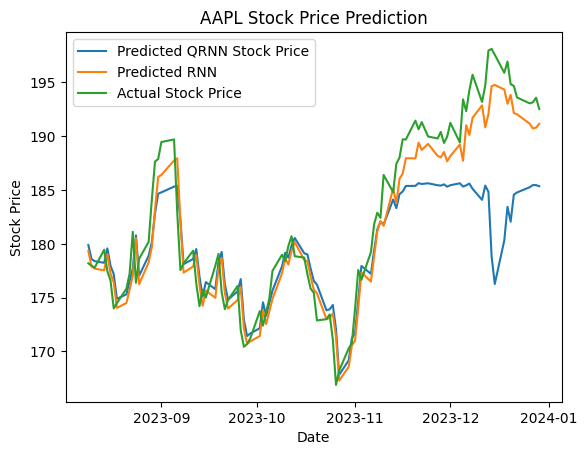

In [48]:
print(x_test.shape)
with torch.no_grad():
    rnn_predictions = []
    for seq in x_test:
        rnn_predictions += [model(seq).item()]
    
    rnn_predictions = torch.Tensor(rnn_predictions)
    print(rnn_predictions)
    plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted QRNN Stock Price')
    plt.plot(stock_data.index[-len(predictions):], scaler.inverse_transform(rnn_predictions.reshape(-1, 1)), label='Predicted RNN')
    plt.plot(stock_data.index[-len(predictions):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Stock Price')
    plt.title(f'{stock_symbol} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [49]:
acc = accuracy(scaler.inverse_transform(rnn_predictions.reshape(-1, 1)), scaler.inverse_transform(y_test.reshape(-1, 1)))
acc

0.9998201877484965